# Multi-class SVM with RBF kernel for activity classification from UCI HAR dataset

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from hypopt import GridSearch
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.neighbors import KNeighborsClassifier

## 1. Loading Data

In [2]:
#filepaths
base = 'UCI HAR Dataset/'
f_x_train = base + 'train/X_train.txt'
f_x_test = base + 'test/X_test.txt'
f_y_train = base + 'train/Y_train.txt'
f_y_test = base + 'test/Y_test.txt'

In [3]:
def readX(filename):
    # Using readlines() 
    file = open(filename, 'r') 
    Lines = file.readlines() 
    vec_arr = []
    for line in Lines: 
        vec = []
        line = line.strip()
        for word in line.split():
            vec.append(float(word))
        vec_arr.append(vec)
    X = np.array(vec_arr)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

In [4]:
def readY(filename):
    # Using readlines() 
    file = open(filename, 'r') 
    Lines = file.readlines() 
    vec_arr = []
    for line in Lines:
        line = line.strip()
        vec_arr.append(int(line))
    return np.array(vec_arr)

In [5]:
X_train = readX(f_x_train)
X_test = readX(f_x_test)
Y_train = readY(f_y_train)
Y_test = readY(f_y_test)
data = np.append(X_train, Y_train.reshape([Y_train.shape[0], 1]), axis = 1)

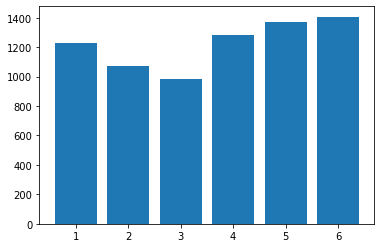

In [6]:
classes, counts = np.unique(Y_train, return_counts=True)
plt.bar(classes, counts)
plt.show()

# 2. PCA for reference

In [7]:
pca = PCA(n_components=20)
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

0.7737196130518785


In [8]:
data_pca = np.append(X_train_pca, Y_train.reshape([Y_train.shape[0], 1]), axis = 1)

In [9]:
def get_acc(X, Y, model):
    Y_pred = model.predict(X)
    corr = 0.0
    for i in range(Y_pred.shape[0]):
        if Y_pred[i] == Y[i]:
            corr+=1
    return (corr/Y.shape[0])

# 3. Grid search on RBF SVM

In [10]:
clf = SVC()
parameters=[{'gamma': [0.01, 0.001, 0.0001, 0.00001], 'C': [10, 100, 1000,10000]}]

In [15]:
model=GridSearchCV(clf,parameters,n_jobs=-1,cv=10,verbose=10)
model.fit(X_train.tolist(),Y_train.tolist())

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [10, 100, 1000, 10000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [16]:
get_acc(X_test, Y_test, model)

0.9653885307091958

In [17]:
#model.cv_results_
model.best_params_

{'C': 1000, 'gamma': 0.0001}

In [51]:
def plot_svm_grid(model):    
    gammas = [0.01, 0.001, 0.0001, 0.00001]
    Cs = [10, 100, 1000,10000]
    scores = model.cv_results_['mean_test_score'].reshape(len(gammas),len(Cs))
    print(scores)
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.inferno)
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gammas)), gammas)
    plt.yticks(np.arange(len(Cs)), Cs)
    plt.title('Grid Search Accuracy')
    plt.show()

In [12]:
def cross_val_grid(data = data, model = 'svm'):
    best_model = None
    best_acc = 0
    model_arr = [] #10 models from grid search
    for i in range(10): #10 times
        np.random.shuffle(data) #shuffle every time
        clf = SVC()
        parameters=[{'gamma': [0.01, 0.001, 0.0001, 0.00001], 'C': [10, 100, 1000,10000]}]
        model=GridSearchCV(clf,parameters,n_jobs=-1,cv=10,verbose=10)
        model.fit(data[:,:-1].tolist(),data[:,-1].tolist())
        acc = model.best_score_
        model_arr.append(model)
        print(i, "run accuracy =", acc, ", params = ", model.best_params_)
        if(acc > best_acc):
            best_acc = acc
            best_model = model
    print("Best accuracy =", best_acc, ", params = ", best_model.best_params_)
    return best_model

In [27]:
best_svm = cross_val_grid()

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.5min finished


0 run accuracy = 0.9893906420021763 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.4min finished


1 run accuracy = 0.9887105549510338 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.1min finished


2 run accuracy = 0.9877584330794341 , params =  {'C': 1000, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.1min finished


3 run accuracy = 0.9885745375408053 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.5min finished


4 run accuracy = 0.9888465723612623 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.9min finished


5 run accuracy = 0.9889825897714908 , params =  {'C': 1000, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 17.1min finished


6 run accuracy = 0.9893906420021763 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.8min finished


7 run accuracy = 0.9888465723612623 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.2min finished


8 run accuracy = 0.9885745375408053 , params =  {'C': 1000, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.5min finished


9 run accuracy = 0.9877584330794341 , params =  {'C': 100, 'gamma': 0.001}
Best accuracy = 0.9893906420021763 , params =  {'C': 100, 'gamma': 0.001}


In [32]:
get_acc(X_test, Y_test, best_svm)

0.9633525619273838

[[0.94382481, 0.98571817, 0.97674102, 0.94572905], [0.94382481, 0.98939064, 0.98408596, 0.97646899], [0.94382481, 0.98925462, 0.98775843, 0.98408596], [0.94382481, 0.98925462, 0.98612622, 0.98571817]]


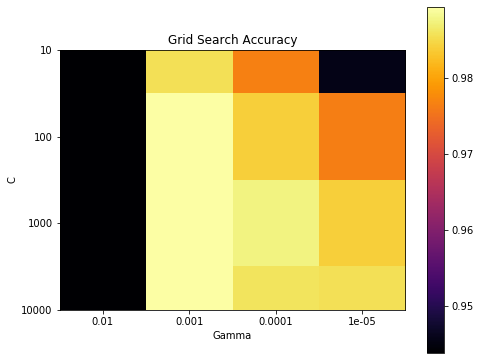

In [52]:
plot_svm_grid(best_svm)

In [13]:
best_svm_pca = cross_val_grid(data = data_pca)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   53.5s finished


0 run accuracy = 0.9370239390642002 , params =  {'C': 10, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   53.5s finished


1 run accuracy = 0.934575625680087 , params =  {'C': 10, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   53.1s finished


2 run accuracy = 0.9357997823721437 , params =  {'C': 100, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   53.0s finished


3 run accuracy = 0.9381120783460283 , params =  {'C': 10, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   54.3s finished


4 run accuracy = 0.9374319912948857 , params =  {'C': 10, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   52.5s finished


5 run accuracy = 0.9359357997823722 , params =  {'C': 10, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   52.7s finished


6 run accuracy = 0.9344396082698585 , params =  {'C': 10, 'gamma': 0.01}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   52.6s finished


7 run accuracy = 0.9352557127312296 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   53.6s finished


8 run accuracy = 0.9353917301414582 , params =  {'C': 100, 'gamma': 0.001}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   52.9s finished


9 run accuracy = 0.9355277475516867 , params =  {'C': 10, 'gamma': 0.01}
Best accuracy = 0.9381120783460283 , params =  {'C': 10, 'gamma': 0.01}


NameError: name 'plot_svm_grid' is not defined

[[0.93811208 0.92777476 0.90669206 0.88424918]
 [0.93239935 0.93552775 0.91988575 0.90356366]
 [0.92723069 0.93498368 0.92682263 0.91417301]
 [0.92355822 0.93076714 0.92940696 0.92097388]]


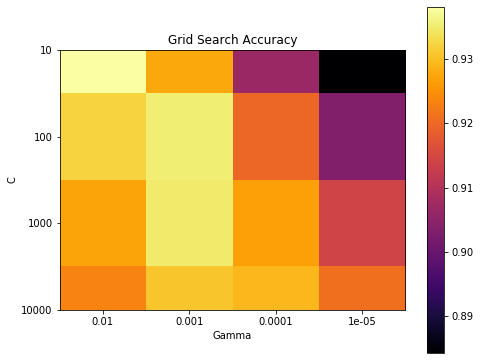

In [15]:
plot_svm_grid(best_svm_pca)

In [16]:
get_acc(X_test_pca, Y_test, best_svm_pca)

0.8863250763488293

# 4. Comparison with other classifiers

In [46]:
# DT on raw data
dt = DecisionTreeClassifier()
dt = dt.fit(X_train,Y_train)

In [47]:
get_acc(X_test, Y_test, dt)

0.8008143875127248

In [45]:
# DT on pca
dt_pca = DecisionTreeClassifier()
dt_pca = dt_pca.fit(X_train_pca,Y_train)

In [48]:
get_acc(X_test_pca, Y_test, dt_pca)

0.7743467933491687

In [38]:
best_svm = SVC(C=100, gamma = 0.001)
best_svm.fit(X_train, Y_train)
acc = get_acc(X_test, Y_test, best_model)
print(acc)

0.9633525619273838


In [15]:
def print_conf(X, Y, model):
    activities = {1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS', 4:'SITTING', 5:'STANDING', 6:'LAYING'}
    Y_pred = model.predict(X)
    array = np.zeros((np.unique(Y).shape[0], np.unique(Y).shape[0])) # confusion matrix
    for i, y in enumerate(Y_pred):
        array[int(y)-1][int(Y[i])-1]+=1
    print(array)
    plt.figure(figsize=(10,7))
    
    sn.heatmap(array, annot=True, fmt='g', xticklabels = list(activities.values()), yticklabels = list(activities.values())) # font size
    plt.show()

[[477.   4.   4.   0.   0.   0.]
 [  9. 465.  20.   1.   0.   0.]
 [ 10.   2. 396.   0.   0.   0.]
 [  0.   0.   0. 451.  19.   0.]
 [  0.   0.   0.  37. 513.   0.]
 [  0.   0.   0.   2.   0. 537.]]


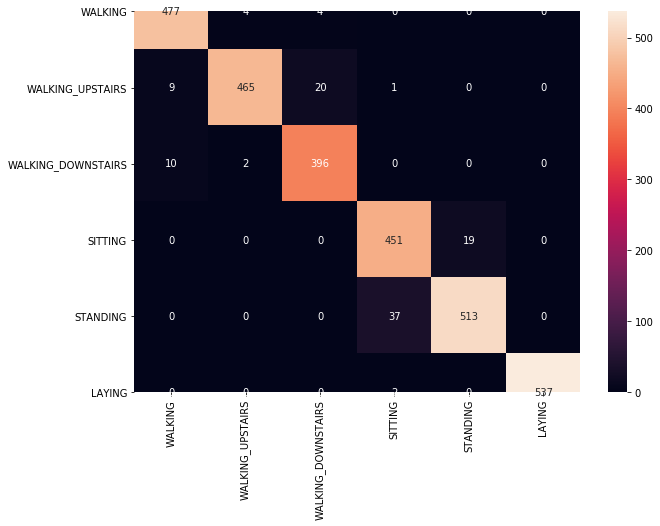

In [39]:
print_conf(X_test, Y_test,best_svm)

[[447.  28.  18.   0.   0.   0.]
 [  7. 426.  36.   0.   0.   0.]
 [ 42.  17. 366.   3.   2.   2.]
 [  0.   0.   0. 434. 103.  21.]
 [  0.   0.   0.  51. 427.   2.]
 [  0.   0.   0.   3.   0. 512.]]


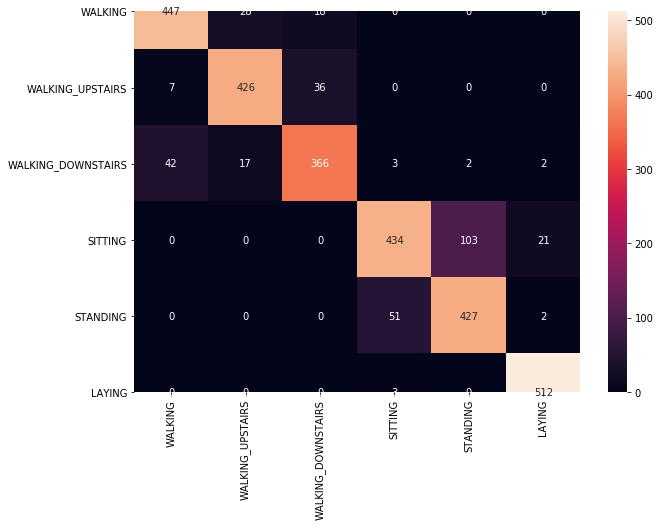

In [41]:
print_conf(X_test_pca, Y_test,best_svm_pca)

[[408.  52.  14.   0.   0.   0.]
 [ 52. 369.  39.   0.   0.   0.]
 [ 36.  50. 367.   0.   0.   0.]
 [  0.   0.   0. 429. 282.   0.]
 [  0.   0.   0.  62. 250.   0.]
 [  0.   0.   0.   0.   0. 537.]]


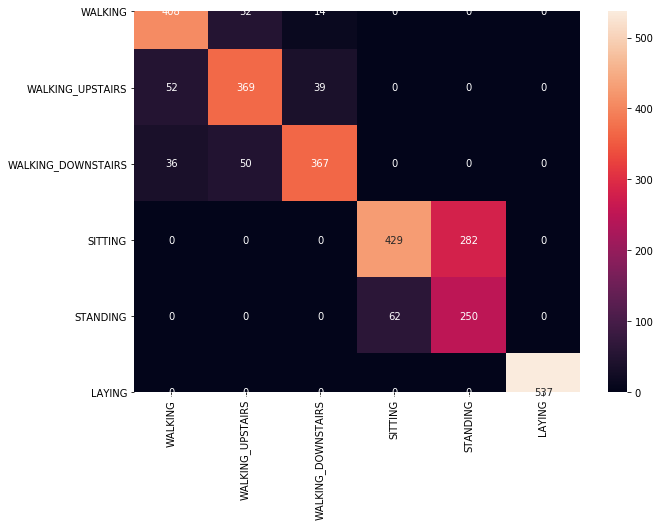

In [49]:
print_conf(X_test, Y_test, dt)

[[389.  47.  58.   0.   0.   0.]
 [ 33. 376.  66.   1.   0.   0.]
 [ 74.  48. 296.   0.   0.   0.]
 [  0.   0.   0. 340. 144.  36.]
 [  0.   0.   0. 142. 382.   2.]
 [  0.   0.   0.   8.   6. 499.]]


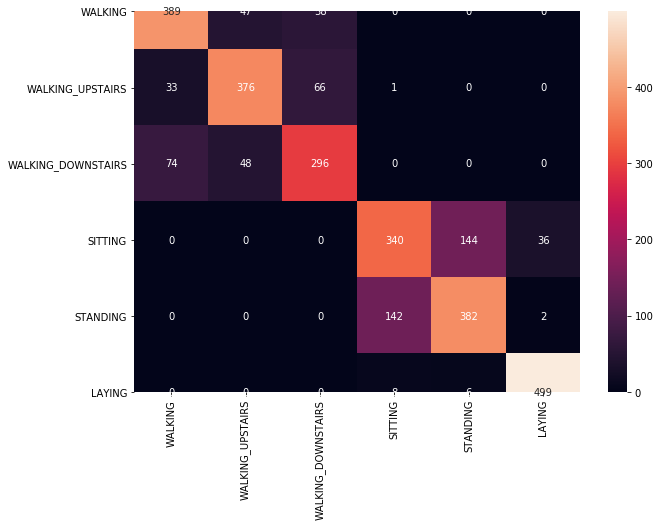

In [50]:
print_conf(X_test_pca, Y_test,dt_pca)

In [61]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [62]:
get_acc(X_test, Y_test, neigh)

0.8744485917882593

In [65]:
clf = KNeighborsClassifier()
parameters=[{'n_neighbors': [4,5,6]}]
neigh=GridSearchCV(clf,parameters,n_jobs=-1,cv=10,verbose=10)
neigh.fit(X_train,Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   19.8s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   20.2s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   25.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid=[{'n_neighbors': [4, 5, 6]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [70]:
print(neigh.best_params_)
get_acc(X_test, Y_test, neigh)

{'n_neighbors': 6}


0.8856464200882254

[[475.  48.  54.   0.   0.   0.]
 [  3. 421.  49.   1.   0.   0.]
 [ 18.   2. 317.   0.   0.   0.]
 [  0.   0.   0. 418.  58.  25.]
 [  0.   0.   0.  69. 474.   7.]
 [  0.   0.   0.   3.   0. 505.]]


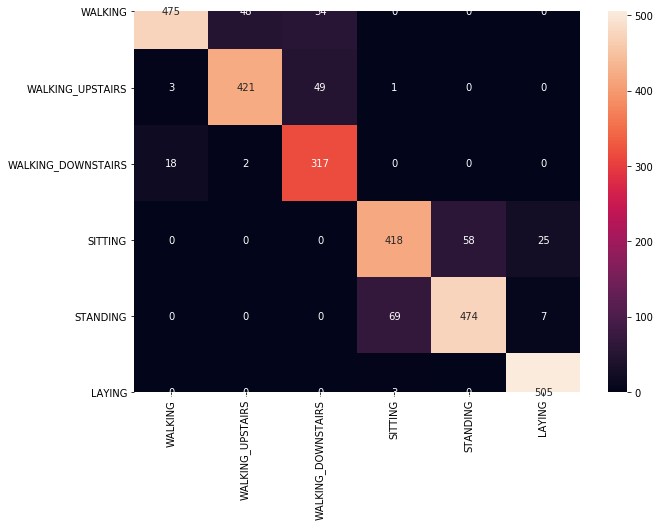

In [72]:
print_conf(X_test, Y_test,neigh)

In [67]:
clf_pca = KNeighborsClassifier()
parameters=[{'n_neighbors': [4,5,6]}]
neigh_pca=GridSearchCV(clf,parameters,n_jobs=-1,cv=10,verbose=10)
neigh_pca.fit(X_train_pca,Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1000s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid=[{'n_neighbors': [4, 5, 6]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [69]:
print(neigh_pca.best_params_)
get_acc(X_test_pca, Y_test, neigh_pca)

{'n_neighbors': 5}


0.8449270444519851

[[448.  42.  46.   0.   0.   0.]
 [ 16. 413.  52.   1.   0.   0.]
 [ 32.  16. 322.   0.   0.   0.]
 [  0.   0.   0. 347.  76.  29.]
 [  0.   0.   0. 142. 456.   4.]
 [  0.   0.   0.   1.   0. 504.]]


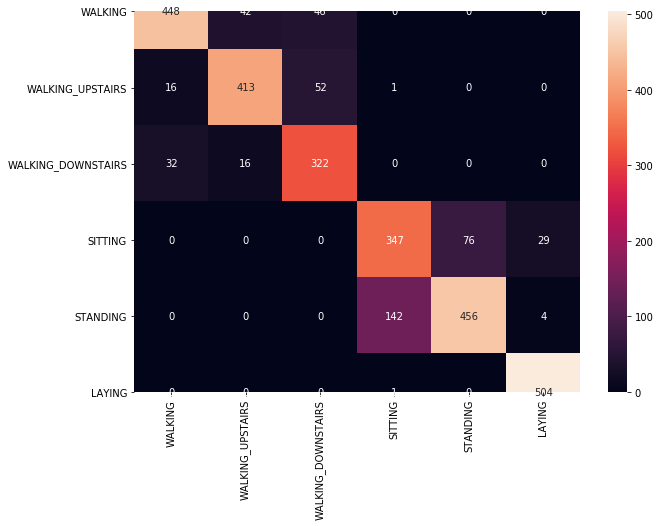

In [71]:
print_conf(X_test_pca, Y_test,neigh_pca)

In [74]:
clf_lin = SVC(kernel = 'linear')
parameters=[{'C': [10, 100, 1000,10000]}]
model_lin=GridSearchCV(clf_lin,parameters,n_jobs=8,cv=10,verbose=10)
model_lin.fit(X_train.tolist(),Y_train.tolist())

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   54.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done  30 out of  40 | elapsed:  2.8min remaining:   56.5s
[Parallel(n_jobs=8)]: Done  35 out of  40 | elapsed:  3.3min remaining:   28.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  3.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=8, param_grid=[{'C': [10, 100, 1000, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [75]:
print(model_lin.best_params_)
get_acc(X_test, Y_test, model_lin)

{'C': 10}


0.9582626399728538

[[484.   8.   3.   0.   0.   0.]
 [  7. 460.  11.   2.   0.   0.]
 [  5.   3. 406.   0.   0.   0.]
 [  0.   0.   0. 443.  38.   0.]
 [  0.   0.   0.  46. 494.   0.]
 [  0.   0.   0.   0.   0. 537.]]


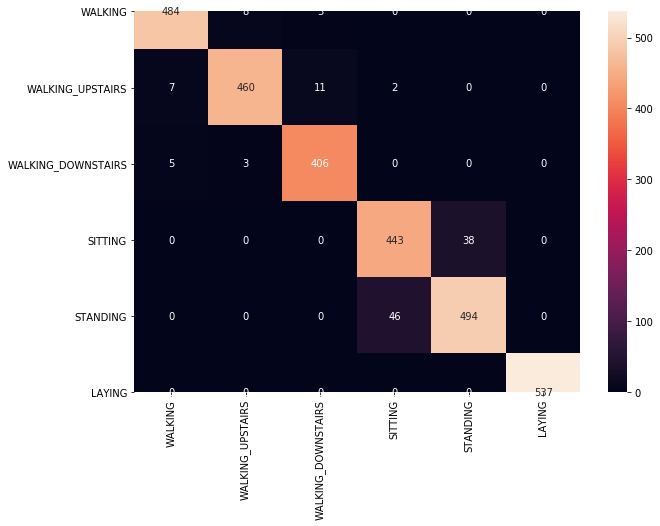

In [77]:
print_conf(X_test, Y_test, model_lin)

In [10]:
clf_lin_pca = SVC(kernel = 'linear')
parameters=[{'C': [10, 100, 1000, 10000]}]
model_lin_pca=GridSearchCV(clf_lin_pca,parameters,n_jobs=-1,cv=10,verbose=10)
model_lin_pca.fit(X_train_pca,Y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 22.3min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 81.4min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 106.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 106.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=-1, param_grid=[{'C': [10, 100, 1000, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [13]:
print(model_lin_pca.best_params_)
get_acc(X_test_pca, Y_test, model_lin_pca)

{'C': 100}


0.8761452324397693

[[439.  17.   8.   0.   0.   0.]
 [ 15. 429.  47.   1.   0.   0.]
 [ 42.  25. 365.   0.   0.   0.]
 [  0.   0.   0. 431. 133.  18.]
 [  0.   0.   0.  55. 399.   0.]
 [  0.   0.   0.   4.   0. 519.]]


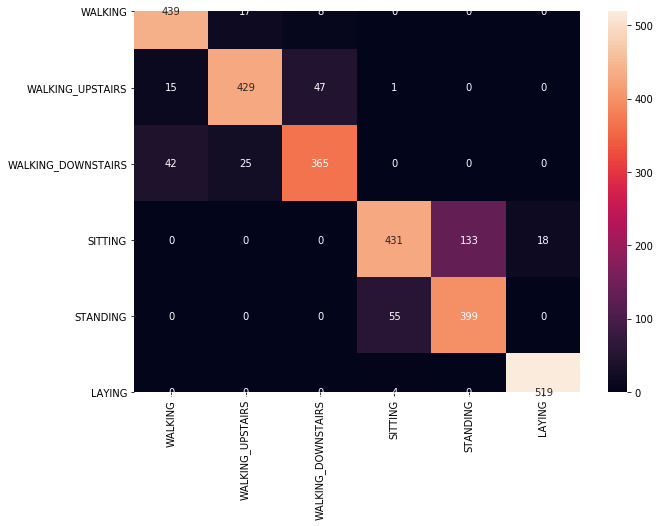

In [16]:
print_conf(X_test_pca, Y_test, model_lin_pca)

In [11]:
def get_conf(X, Y, model):
    #activities = {1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS', 4:'SITTING', 5:'STANDING', 6:'LAYING'}
    Y_pred = model.predict(X)
    array = np.zeros((np.unique(Y).shape[0], np.unique(Y).shape[0])) # confusion matrix
    for i, y in enumerate(Y_pred):
        array[int(y)-1][int(Y[i])-1]+=1
    return (array)
    #plt.figure(figsize=(10,7))
    
    #sn.heatmap(array, annot=True, fmt='g', xticklabels = list(activities.values()), yticklabels = list(activities.values())) # font size
    #plt.show()

In [14]:
def get_acc_class(arr):
    acc = []
    for i, row in enumerate(arr):
        acc.append(float(row[i])/float(sum(row)))
    print(acc)
    print(sum(acc)/len(acc))

In [15]:
get_acc_class([[439.,  17. ,  8. ,  0.,   0. ,  0.],
 [ 15. ,429. , 47.  , 1. ,  0. ,  0.],
 [ 42. , 25., 365. ,  0. ,  0.  , 0.],
 [  0. ,  0. ,  0., 431. ,133. , 18.],
 [  0. ,  0. ,  0.  ,55. ,399. ,  0.],
 [  0. ,  0. ,  0. ,  4.  , 0. ,519.]])

[0.9461206896551724, 0.8719512195121951, 0.8449074074074074, 0.7405498281786942, 0.8788546255506607, 0.9923518164435946]
0.8791225977912874


# 5. Final comparison of all classifiers

In [16]:
svm = SVC(C = 1000, gamma = 0.0001)
svm.fit(X_train, Y_train)
get_acc_class(get_conf(X_test, Y_test, svm))

[0.9817813765182186, 0.95625, 0.9782608695652174, 0.9571734475374732, 0.9225225225225225, 1.0]
0.9659980360239054


In [17]:
svm_pca = SVC(C = 10, gamma = 0.01)
svm_pca.fit(X_train_pca, Y_train)
get_acc_class(get_conf(X_test_pca, Y_test, svm_pca))

[0.9468085106382979, 0.8725490196078431, 0.9142156862745098, 0.7266666666666667, 0.8832951945080092, 0.9942528735632183]
0.8896313252097575


In [18]:
svm_lin = SVC(C = 10)
svm_lin.fit(X_train, Y_train)
get_acc_class(get_conf(X_test, Y_test, svm_lin))

[0.9813278008298755, 0.9432048681541582, 0.9541062801932367, 0.9493670886075949, 0.9321100917431193, 0.9962894248608535]
0.959400925731473


In [19]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, Y_train)
get_acc_class(get_conf(X_test, Y_test, neigh))

[0.8431372549019608, 0.89375, 0.9423631123919308, 0.8835616438356164, 0.8198347107438017, 0.9961240310077519]
0.8964617921468436


In [20]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train,Y_train)
get_acc_class(get_conf(X_test, Y_test, dt))

[0.8686868686868687, 0.8288288288288288, 0.8258928571428571, 0.5699481865284974, 0.796812749003984, 1.0]
0.8150282483651727
